In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arabic-text-corpus/corpus-texte-questions.xml


# 1. Installing evaluation dependencies 

In [2]:
!pip install transformers datasets sentencepiece --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.7 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.4.0.6 which is incompatible.
torch 2.6.0+

# 2. Installing arabert to improve the Arabic NLP pipeline by normalizing and cleaning the text.

In [3]:
!pip install arabert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 5.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.8 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=6ed409c0d167fc38d806ffe16ce84769a482b91527ce4b0863fe5e435a96877e
  Stored in directory: /root/.cache/pip/wheels/94/08/b4/78657b1541bb704b088317b52429ee4016d9888fe47dbb130f
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.14.1
    Uninstalling emoji-2.14.1:
      Successfully uninstalled emoji-2.14.1


# 3. Preparing the testing Dataset

In [4]:
import xml.etree.ElementTree as ET

# Load XML
tree = ET.parse('/kaggle/input/arabic-text-corpus/corpus-texte-questions.xml')
root = tree.getroot()

# Print tag names of the first few elements
for child in root.iter():
    print(child.tag)
    break  # remove this break to see more tags if needed|

corpus


In [5]:
with open('/kaggle/input/arabic-text-corpus/corpus-texte-questions.xml', 'r', encoding='utf-8') as f:
    for _ in range(20):
        print(f.readline().strip())

<?xml version='1.0' encoding='utf-8'?>
<corpus><texte id="0"><titre>الأسد والفأر
</titre><body>
وسط غابة كبيرة كان هناك
الاسد ملك الغابة نائما تحت
ظل شجرة وكان هناك فأر
صغير يلعب في الجوارثم لاحظ
أن الملك نائم لذلك قرر أن يلعب قليلا صعد على ظهره
وبدأ يتزحلق عبر ذيله إلى الأسفل أعادها مرة واثنتان وثلاث استمتع الفأر بالأمر، انزعج الأسد واستيقظ ثم
أمسك بالفأر الصغيرأراد أكله استوقفه الفأر الصغير باكيا يترجاه لكي لايكون
وجبة خفيفة له ترجاه الفأر ووعده بأن لايزعجه مرة أخرى
بل لربما يحتاجه في وقت من الأوقات تأثر الأسد بما سمعه ثم ترك الفأر يرحل وبعد بضعة أيام وككل يوم
ملك الغابة يأخذ قيلولته إذ بالصيادي يلقي شبكته عليه ليمسك به فعلا قد وقع في الفخ
بدأ الأسد بالزئير ليسمعه كل من في الغابة حتى الفأر الصغير سمع زئيره ليتذكر أنه
مدين للأسد وعليه المساعدةوأن يرد المعروف بمثله لم يتردد صديقنا
وذهب مسرعا ليرى ماحصل وعندما وصل وجد الأسد تحت الشباك
تسلقها الفأر وبدأ بتمزيقها بأسنانه الحادة
حتى مزقها بالكامل وأخيرا أنقذ الأسد من الفخ ورد له صنيعه ومن ذلك الحين والأسد صديق الفأر.
هناك أصدقاء يعرفون عند

In [6]:
import xml.etree.ElementTree as ET
import re

def parse_custom_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    data = []
    for texte in root.findall("texte"):
        raw_context = texte.find("body").text or ""
        context = re.sub(r'\s+', ' ', raw_context).strip()
        questions_block = texte.find("questions").text

        # Check and split questions using dash
        if questions_block:
            data.append({"input": context, "target": questions_block})
    return data
data = parse_custom_xml("/kaggle/input/arabic-text-corpus/corpus-texte-questions.xml")
train_data = data[:]
print(f"Total examples extracted: {len(data)}")
print(data[10])

Total examples extracted: 1089
{'input': 'في قديم الزمان كان هناك رجل فقير اسمه إحسان يعيش في كوخ خشبي مهترئ و بالكاد يملك قوت يومه. يوما ما حصل على إرث من عم عجوز له توفي خارج البلاد. عندها انقلبت حياته، و اشترى بيتا جديدا. و تقرب منه الجميع و شاركوه بماله كلما اشترى ثوبا او طعاما او أي شيء، اضطر لشرائه لهم. وعندها مر رجل فقير فأهمله الجميع، لكن إحسان لحقه و أعطاه مبلغا من المال، شكره الرجل فرد إحسان بقول اذا كنا لم نساعد بعضنا فمن سنساعد!! عندها مرت الأيام و خسر إحسان كل ماله بما انفق على أصدقائه. طلب المساعدة منهم الا أنهم أبوا ذلك بل و انكروا فضله. جلس وحيدا و جائعا في الجو الماطر و فجاة اقترب منه رجل مغطي رأسه و اصطحبه الى منزله الفخم الجميل. فنظر إحسان و قال كان لي منزل جميل كمنزلك لكنني بعته لاني خسرت كل مالي. عندها كشف الرجل عن وجهه؛ فكان هو الرجل الفقير الذي ساعده إحسان قديما. و قال له خذ هذا عشرة أضعاف مالك الذي أعطيتني إياه لقد اشتغلت في التجارة و جمعت مالا وفيرا بفضل الله ثم بفضل مالك. اذا لم نساعد بعضنا فمن سنساعد؟! الان حان دورك لتعد كما كنت من جديد.', 'target': '\n- كيف 

# 4. Loading our model for evaluation

In [7]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

model = AutoModelForSeq2SeqLM.from_pretrained("NadirFartas/AraT5-trained-11epochs", use_auth_token=token)
tokenizer = AutoTokenizer.from_pretrained(
    "NadirFartas/AraT5-trained-11epochs",
    use_fast=False  # force slow tokenizer
)

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

2025-05-19 17:58:43.598872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747677523.796718      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747677523.854828      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/15.3M [00:00<?, ?B/s]

# 5. Cleaning the memory and enabling the GPU

In [8]:
import gc
import torch

# Clear memory
gc.collect()
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

CUDA available: True
Device: cuda


# 6. Loading the QA evaluation model to score the relevance of generated questions against the full input context

In [9]:
from transformers import pipeline

# Load the QA model for relevance evaluation
qa_model = pipeline("question-answering", model="ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA", device=1)

config.json:   0%|          | 0.00/851 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/538M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/761k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:1


# 7. initializing our approach for generating questions from a given text and the evaluation approach

In [10]:
# Function to segment text into manageable chunks
def segment_by_points_grouped(text, tokenizer, max_tokens=60, min_tokens=30):
    words = text.split()
    chunks = []
    current_chunk = []

    for word in words:
        current_chunk.append(word)
        encoded = tokenizer(' '.join(current_chunk), return_tensors="pt", add_special_tokens=False)
        if encoded.input_ids.shape[1] >= max_tokens:
            last_word = current_chunk.pop()
            chunks.append(' '.join(current_chunk))
            current_chunk = [last_word]

    if current_chunk:
        encoded = tokenizer(' '.join(current_chunk), return_tensors="pt", add_special_tokens=False)
        if chunks and encoded.input_ids.shape[1] < min_tokens:
            chunks[-1] += ' ' + ' '.join(current_chunk)
        else:
            chunks.append(' '.join(current_chunk))

    return chunks

# Function to evaluate the relevance of generated questions
def evaluate_global_relevance(input_text, generated_questions, threshold=0.1):
    results = []
    for question in generated_questions:
        try:
            question_clean = arabert_prep.preprocess(question)
            prediction = qa_model(question=question_clean, context=input_text)
            score = prediction.get("score", 0.0)
            is_relevant = score > threshold
            results.append((question, score, is_relevant))
        except Exception as e:
            results.append((question, 0.0, False))
    return results

# 8. Evaluating the model and saving the result as .csv file for visualization and Error handling

In [11]:
import pandas as pd
from tqdm.notebook import tqdm
from arabert.preprocess import ArabertPreprocessor

arabert_prep = ArabertPreprocessor(model_name="aubmindlab/bert-base-arabertv2")

# Assuming 'data' is your dataset loaded as a list of dictionaries with 'input' keys
subset = data[500:]  # Evaluate on the last 500 entries

log_data = []
total_questions = 0
relevant_questions = 0

for idx, test in enumerate(tqdm(subset, desc="Evaluating")):
    raw_text = test['input']
    input_text = arabert_prep.preprocess(raw_text) 
    input_id = test.get('id', idx)
    paragraphs = segment_by_points_grouped(input_text, tokenizer)

    generated_questions = []
    for paragraph in paragraphs:
        inputs = tokenizer(paragraph, return_tensors="pt", truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model.generate(
            inputs["input_ids"],
            max_length=100,
            num_beams=4,
            early_stopping=True
        )
        question = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_questions.append(question)

    results = evaluate_global_relevance(input_text, generated_questions)

    for question, score, is_relevant in results:
        log_data.append({
            "input_id": input_id,
            "question": question,
            "confidence_score": score,
            "is_relevant": is_relevant
        })
        total_questions += 1
        relevant_questions += int(is_relevant)

# Calculate and display the final relevance accuracy
accuracy = (relevant_questions / total_questions) * 100 if total_questions else 0
print(f"📊 Final Relevance Accuracy: {accuracy:.2f}% ({relevant_questions}/{total_questions})")

# Save the detailed results to a CSV file
df = pd.DataFrame(log_data)
df.to_csv("/kaggle/working/results.csv", index=False)
print("✅ Results saved to results.csv")


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


100%|██████████| 241M/241M [07:03<00:00, 570kiB/s] 


[2025-05-19 18:08:17,179 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


Evaluating:   0%|          | 0/589 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


📊 Final Relevance Accuracy: 83.17% (4617/5551)
✅ Results saved to results.csv


# 9. Visualization: Pie Chart and Bar Chart

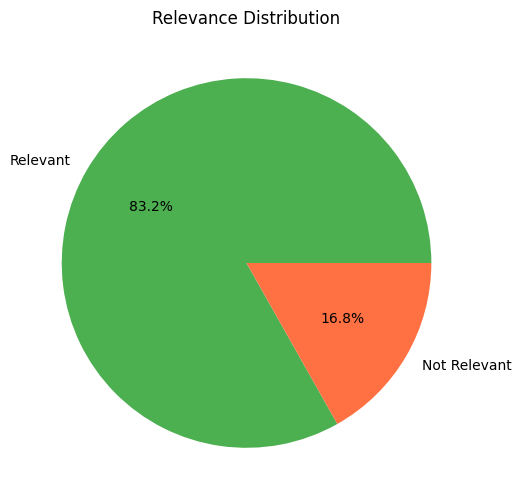

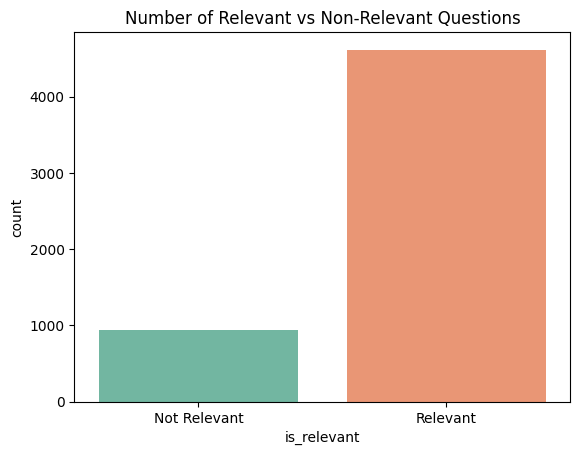

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/kaggle/working/results.csv')

# Pie Chart
relevance_counts = df['is_relevant'].value_counts()
labels = ['Relevant', 'Not Relevant']
colors = ['#4CAF50', '#FF7043']
plt.figure(figsize=(6, 6))
plt.pie(relevance_counts, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title('Relevance Distribution')
plt.show()

# Bar Chart (optional)
sns.countplot(x='is_relevant', data=df, palette='Set2')
plt.xticks([0, 1], ['Not Relevant', 'Relevant'])
plt.title("Number of Relevant vs Non-Relevant Questions")
plt.show()


# 10. Error Analysis: Least Relevant Questions

In [13]:
lowest = df.sort_values(by='confidence_score', ascending=True).head(10)
print("❌ Least relevant questions:")
print(lowest[['question', 'confidence_score']])

❌ Least relevant questions:
                                   question  confidence_score
4765        ما هي العبرة المستخلصة من النص؟          0.001261
3486       استخرج من النص مرادف كلمة: حياة؟          0.001767
4884       ما هي المهنة التي كان يعمل بها ؟          0.002042
4838  ما هو العمل الغريب الذي قام به الشيخ؟          0.002305
4187                         ماذا قال جحا ؟          0.002334
4455    استخرج من السند مرادف كلمة: النجاح؟          0.002436
3748                 هل أطعمت الجد ال+ قط ؟          0.002883
4020   استعيذت سلمى من ال+ شيطان ال+ رجيم ؟          0.002972
3388                  ما هي أفكار ال+ جميع؟          0.003134
5109                     ماذا تريد من منال؟          0.003584


# - Saving the results

In [14]:
lowest.to_csv("/kaggle/working/least_relevant_questions.csv", index=False)

# 11. Top-10 Questions: Most Confident

In [15]:
top_k = df.sort_values(by='confidence_score', ascending=False).head(10)
print("🔥 Top 10 questions by confidence:")
print(top_k[['question', 'confidence_score']])

🔥 Top 10 questions by confidence:
                                           question  confidence_score
2702  ما هي الجزيرة التي كانت تقع في منتصف ال+ بحر؟          0.992532
1045              أين يقع متحف ال+ الوطني لل+ علوم؟          0.989887
2945             ماذا كان يبدو على صاحب ال+ بستان ؟          0.987862
2599                         من تقدم إلى أبي عبيد ؟          0.985787
3045                              من يشتري العبيد ؟          0.985414
3413                          ماذا رأى على ال+ أرض؟          0.985253
2449                   ماذا طلب الصياد من الصيادين؟          0.984510
1120                     من اغتال زبير بن ال+ عوام؟          0.982013
5289                  متى وصل أرمسترونغ إلى القمر ؟          0.980624
1510                        ماذا ضاع أحد طيور ال+ ؟          0.979495


# - Saving the results

In [16]:
top_k.to_csv("/kaggle/working/top10_questions.csv", index=False)


# 12. Filter Only Relevant Questions

In [17]:
relevant_only = df[df['is_relevant'] == True]
relevant_only.to_csv("/kaggle/working/relevant_questions_only.csv", index=False)
print(f"✅ Saved {len(relevant_only)} relevant questions.")

✅ Saved 4617 relevant questions.
